In [1]:
from typing import List, Optional
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
import shap

from tqdm.notebook import tqdm

import re
import os

from functools import partial
from scipy.stats import mode
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.manifold import TSNE
# import optuna

from View import MyClass
mc = MyClass()

In [2]:
def shap_shap(X_train, model, shap_limit=0):
    np.random.seed(10)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    # Суммированная важность признаков
    shap.summary_plot(
        shap_values, X_train, plot_type="bar", max_display=50)
    
    shap_values_importance = pd.DataFrame({
    "importance": np.abs(shap_values).mean(axis=0),
    "feature": X_train.columns
        })
    shap_values_importance = shap_values_importance.sort_values(
        by="importance", ascending=False
        )
    shap_values_importance = shap_values_importance.reset_index(drop=True) 
    
    
#     print(shap_values_importance)
    # Набор топ признаков
    best_feature = shap_values_importance.feature.to_list()
    dict_features = dict(zip(best_feature, shap_values_importance["importance"]))
    # Набор признаков для удаления
    features_to_drop = shap_values_importance[shap_values_importance["importance"] <= shap_limit]
    features_to_drop = features_to_drop.feature.to_list()
    
    return features_to_drop, dict_features

In [3]:
class MissedColumnsError(Exception):
    pass

class CategoricalFrequencyTransformer(BaseEstimator, TransformerMixin):
    """
    Трансформер для осуществляения FrequencyEncoding, кодирование
    признаков с помощью частотного анализа.

    Parameters
    ----------
    use_cols: List[str]
        Список с названием признаков, для которых нужно
        применить преобразование.

    Attributes
    ----------
    feature_mappers: dict
        Словарь со словарем преобразования для каждого
        признака, перечисленного в self.use_cols.

    """
    def __init__(self, use_cols: List[str]) -> None:
        self.use_cols = use_cols

    def _check_data(self, X):
        """
        Проверка наличия признаков в self.user_cols во
        входящей матрице признаков. Если признак отсутствует
        в X, то возбуждается исключение MissedColumnsError.

        """
        missed_cols = list(set(self.use_cols) - set(X.columns))
        if missed_cols:
            raise MissedColumnsError(
                f"Missed columns: {missed_cols}"
            )

    def fit(self, X, y=None):
        """
        Вычисление частот для заданных признаков.

        Parameters
        ----------
        X: array-like, shape = [n_samples, n_features]
            Матрица признаков для вычисления частот.

        Returns
        -------
        self

        """
        self._check_data(X)
        self.feature_mappers = {}

        for feature in self.use_cols:
            unique, counts = np.unique(X[feature], return_counts=True)
            mapper = pd.Series(data=counts, index=unique)
            self.feature_mappers[feature] = mapper

        return self

    def transform(self, X, y=None):
        # ToDO -> расширить использование на Numpy-объекты
        self._check_data(X)
        check_is_fitted(self, "feature_mappers")
        for feature in self.use_cols:
            mapper = self.feature_mappers.get(feature)
            X[feature] = X[feature].map(mapper)

        return X

In [4]:
print(mc.__doc__)

Визуализация и предобработка данных
# Первичный обзор работа с памятью
* Метод "view_csv" принимает DataFrame и выводит данные о нем, переводит название столбцов в lower
возвращает data.columns, categorical, numerical
* Метод optim_memory оптимизирует память занимаемую данными, принимает DataFrame, возвращает DataFrame

# Статистика
* Метод "stat_frame" принимает DataFrame и возвращает DataFrame со статистиками
* Метод "corr" принимает DataFrame и target : str
* Метод corr_sign принимает data: DataFrame, drop_sign:List ( корреляция между признаками)
* Метод nonlianer_comun принимает data: DataFrame, numerical: list(список числовых признаков
target: str(по умолчанию "class"), num_sign: int(кол-во столбцов с нелинейной связью)
* Метод "percentile_99_1" принимает data: DataFrame, data_stat : DataFrame( возвращает метод "stat_frame"), flag: bool(
если флаг равен True возвращает фрейм где максимум заменен на 99 перцентиль, а минимум на 1 перцентиль)
по умолчанию flag = False
возвращат данны

In [5]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submission.csv')


In [6]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [7]:
Random_seed = 1234123

In [8]:
train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1


In [9]:
train.columns, categorical, numerical = mc.view_csv(train)

rows: 159256, cols: 23
Всего категориальных признаков: 0
Index([], dtype='object')
Всего числовых признаков: 23
['ldl', 'serum creatinine', 'eyesight(right)', 'dental caries', 'systolic', 'gtp', 'ast', 'alt', 'hearing(right)', 'urine protein', 'hdl', 'eyesight(left)', 'relaxation', 'cholesterol', 'triglyceride', 'weight(kg)', 'smoking', 'hemoglobin', 'age', 'waist(cm)', 'height(cm)', 'fasting blood sugar', 'hearing(left)']
В данных пропусков нету


In [10]:
base_columns = train.drop('smoking', axis=1).columns

In [11]:
test.columns, categorical, numerical = mc.view_csv(test)

rows: 106171, cols: 22
Всего категориальных признаков: 0
Index([], dtype='object')
Всего числовых признаков: 22
['ldl', 'serum creatinine', 'eyesight(right)', 'dental caries', 'systolic', 'gtp', 'ast', 'alt', 'hearing(right)', 'urine protein', 'hdl', 'eyesight(left)', 'relaxation', 'cholesterol', 'triglyceride', 'weight(kg)', 'hemoglobin', 'age', 'waist(cm)', 'height(cm)', 'fasting blood sugar', 'hearing(left)']
В данных пропусков нету


In [5]:
def fit_score(X):
    x_train, x_valid, y_train, y_valid, x_test, y_test = mc.train_split(X, "smoking")
#     params = {
#                     "n_estimators": 5000,
#                     "learning_rate": 0.01,
#                     "loss_function": "Logloss",
#                     "eval_metric": "AUC",
#                     "task_type": "CPU",
# #                     "max_bin": 20,
#                     "verbose": 100,
#                     "max_depth": 6,
#                     "l2_leaf_reg": 10,
#                     "early_stopping_rounds": 50,
#                     "thread_count": 8,
#                     "random_seed": 42
#                 }
    params = {
        "n_estimators": 5000,
        "learning_rate": 0.01,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",
        #"max_bin": 20,
        "verbose": 500,
        "max_depth": 6,
        "l2_leaf_reg": 10,
        "early_stopping_rounds": 50,
        "thread_count": 6,
        "random_seed": 42
        }
    model, rocauc_score = mc.catboost_base(x_train, x_valid, y_train, y_valid, params=params)
    pred = model.predict_proba(x_test)[:,1]
    pred = np.where(pred > 0.5, 1, 0)
    print("test score: ", round(roc_auc_score(pred, y_test), 5))
    return model, x_train

In [13]:
model = fit_score(train)

x_train.shape: (101923, 22) x_valid.shape:  (31852, 22) y_train.shape:  (101923,) y_valid.shape:  (31852,) x_test.shape:  (25481, 22) y_test.shape:  (25481,)
0:	total: 148ms	remaining: 12m 21s
500:	total: 6.02s	remaining: 54.1s
1000:	total: 12.1s	remaining: 48.4s
1500:	total: 18.2s	remaining: 42.4s
2000:	total: 24.3s	remaining: 36.5s
2500:	total: 30.5s	remaining: 30.5s
3000:	total: 36.8s	remaining: 24.5s
3500:	total: 43.1s	remaining: 18.5s
4000:	total: 49.3s	remaining: 12.3s
4500:	total: 55.6s	remaining: 6.17s
4999:	total: 1m 1s	remaining: 0us
roc_auc_score:  0.7848129278502638
confusion_matrix:  [[13529  4309]
 [ 2646 11368]]
accuracy_score:  0.7816463644355143
test score:  0.77971


0.77761

In [13]:
stat_train = mc.stat_frame(train)
stat_train.head(n=train.shape[1])

,count,max,quantile_99,max_vs_quantile_99,min,quantile_1,min_vs_quantile_1,nunique,isna_sum,dtype
age,159256,85,75.0,682,20,20.0,0,18,0,int64
height(cm),159256,190,185.0,44,135,145.0,419,14,0,int64
weight(kg),159256,130,100.0,843,30,45.0,942,28,0,int64
waist(cm),159256,127.0,104.0,1584,51.0,63.0,1184,531,0,float64
eyesight(left),159256,9.9,1.5,712,0.1,0.2,710,20,0,float64
eyesight(right),159256,9.9,1.5,672,0.1,0.2,803,17,0,float64
hearing(left),159256,2,2.0,0,1,1.0,0,2,0,int64
hearing(right),159256,2,2.0,0,1,1.0,0,2,0,int64
systolic,159256,213,154.0,1482,77,95.0,1550,112,0,int64
relaxation,159256,133,100.0,848,44,59.0,1500,75,0,int64


In [14]:
stat_test = mc.stat_frame(test)

In [15]:
train = mc.percentile_99_1(train, flag=True)
test = mc.percentile_99_1(test, flag=True)

In [16]:
model, X_train = fit_score(train)

x_train.shape: (101923, 22) x_valid.shape:  (31852, 22) y_train.shape:  (101923,) y_valid.shape:  (31852,) x_test.shape:  (25481, 22) y_test.shape:  (25481,)
roc_auc_score:  0.7858424350784161
confusion_matrix:  [[13553  4285]
 [ 2636 11378]]
accuracy_score:  0.7827138013311566
test score:  0.77976


0.77976

## new features

In [16]:
train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine protein,serum creatinine,ast,alt,gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,104.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1


### cholesterol

In [17]:
train['cholesterol'] = round(train['cholesterol'] / 38.66, 3)
test['cholesterol'] = round(test['cholesterol'] / 38.66, 3)

In [18]:
def norm_cholesterol(x):
    x = x.copy()
    x['norm_cholesterol'] = 1
    q = x.loc[x['age'] > 0].loc[x['age'] < 19]
    w = x.loc[x['age'] > 20].loc[x['age'] < 29]
    r = x.loc[x['age'] > 30].loc[x['age'] < 39]
    t = x.loc[x['age'] > 40].loc[x['age'] < 49]
    p = x.loc[x['age'] > 50]
    if len(q) > 0:
        s = q[(q['cholesterol'] < 3.10) | (q['cholesterol'] > 5.95)]
        if len(s) > 0:
            print(' 19 {s}', len(s))
            ind = s.index
            x.loc[ind, "norm_cholesterol"] = 0
            
    if len(w) > 0:
        s = w[(w['cholesterol'] < 3.10) | (w['cholesterol'] > 6.21)]
        if len(s) > 0:
            print(' 29 {s}',len(s))
            ind = s.index
            x.loc[ind, "norm_cholesterol"] = 0

    if len(r) > 0:
        s = r[(r['cholesterol'] < 3.62) | (r['cholesterol'] > 6.98)]
        if len(s) > 0:
            print(' 39 {s}',len(s))
            ind = s.index
            x.loc[ind, "norm_cholesterol"] = 0
            
    if len(t) > 0:
        s = t[(t['cholesterol'] < 3.88) | (t['cholesterol'] > 8.02)]
        if len(s) > 0:
            print(' 49 {s}',len(s))
            ind = s.index
            x.loc[ind, "norm_cholesterol"] = 0
    if len(p) > 0:
        s = p[(p['cholesterol'] < 4.14) | (p['cholesterol'] > 8.53)]
        if len(s) > 0:
            print(' all {s}',len(s))
            ind = s.index
            x.loc[ind, "norm_cholesterol"] = 0
    return x
            
         

In [19]:
# t = pd.DataFrame()
train = norm_cholesterol(train)
test = norm_cholesterol(test)

 29 {s} 132
 39 {s} 119
 49 {s} 453
 all {s} 4965
 29 {s} 97
 39 {s} 69
 49 {s} 307
 all {s} 3280


### fasting blood sugar

In [20]:
train['fasting blood sugar'].value_counts().keys()

Int64Index([ 94,  97,  92,  95,  91,  93,  98,  99,  96,  90,  89,  88, 101,
            102,  87, 100, 103,  86, 104,  85, 105, 106,  84, 107, 108,  83,
             82, 109, 110, 112,  75,  81, 111, 153,  80, 113, 115, 114,  79,
             78, 119, 117, 116,  77, 121, 120, 123, 118, 122, 124,  76, 128,
            132, 126, 125, 127, 131, 129, 130, 133, 138, 134, 139, 144, 143,
            136, 142, 137, 135, 141, 147, 140, 152, 145, 150, 149, 146, 151,
            148],
           dtype='int64')

In [21]:
train['norm blood sugar'] = np.where(train['fasting blood sugar'] < 100, 0, 1)
test['norm blood sugar'] = np.where(test['fasting blood sugar'] < 100, 0, 1)

### triglyceride

In [22]:
train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine protein,serum creatinine,ast,alt,gtp,dental caries,smoking,norm_cholesterol,norm blood sugar
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,4.449,300,40,75,16.5,1,1.0,22,25,27,0,1,1,0
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,5.018,55,57,126,16.2,1,1.1,27,23,37,1,0,1,1
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,4.604,197,45,93,17.4,1,0.8,27,31,53,0,1,1,0
3,35,180,95,104.0,1.5,1.2,1,1,131,88,91,4.656,203,38,102,15.9,1,1.0,20,27,30,1,0,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,4.009,87,44,93,15.4,1,0.8,19,13,17,0,1,1,0


In [23]:
train['triglyceride'] = round(train['triglyceride'] / 38.66, 3)
test['triglyceride'] = round(test['triglyceride'] / 38.66, 3)

норма для человека 0,2–1,7 ммоль/л

In [24]:
train['norm_triglyceride'] = np.where((train['triglyceride'] > 0.2) & (train['triglyceride'] < 1.7), 0, 1)
test['norm_triglyceride'] = np.where((test['triglyceride'] > 0.2) & (test['triglyceride'] < 1.7), 0, 1)

In [25]:
train['norm_triglyceride'].value_counts()

1    132461
0     26795
Name: norm_triglyceride, dtype: int64

### hdl


In [26]:
train['hdl'] = round(train['hdl'] / 38.66, 3)
test['hdl'] = round(test['hdl'] / 38.66, 3)

In [27]:
train['norm_hdl'] = np.where(train['hdl'] > 1.1 , 0, 1)
test['norm_hdl'] = np.where(test['hdl'] > 1.1 , 0, 1)

### ldl

Норма – 1,71−3,5 ммоль/л

In [28]:
train['ldl'] = round(train['ldl'] / 38.66, 3)
test['ldl'] = round(test['ldl'] / 38.66, 3)

In [29]:
train['norm_ldl'] = np.where((train['ldl'] > 1.71) & (train['ldl'] < 3.5), 0, 1)
test['norm_ldl'] = np.where((test['ldl'] > 1.71) & (test['ldl'] < 3.5), 0, 1)

### hemoglobin

In [30]:
train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine protein,serum creatinine,ast,alt,gtp,dental caries,smoking,norm_cholesterol,norm blood sugar,norm_triglyceride,norm_hdl,norm_ldl
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,4.449,7.760,1.035,1.940,16.5,1,1.0,22,25,27,0,1,1,0,1,1,0
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,5.018,1.423,1.474,3.259,16.2,1,1.1,27,23,37,1,0,1,1,0,0,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,4.604,5.096,1.164,2.406,17.4,1,0.8,27,31,53,0,1,1,0,1,0,0
3,35,180,95,104.0,1.5,1.2,1,1,131,88,91,4.656,5.251,0.983,2.638,15.9,1,1.0,20,27,30,1,0,1,0,1,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,4.009,2.250,1.138,2.406,15.4,1,0.8,19,13,17,0,1,1,0,1,0,0


для мужчин составляет от 14 до 18 г / дл; для женщин составляет от 12 до 16 г

In [31]:
train['norm_hemoglobin'] = np.where((train['hemoglobin'] > 12) & (train['hemoglobin'] < 18), 0, 1)
test['norm_hemoglobin'] = np.where((test['hemoglobin'] > 12) & (test['hemoglobin'] < 18), 0, 1)

### ast

у взрослого человека - от 10 до 30 Единиц на литр

In [32]:
train['norm_ast'] = np.where((train['ast'] > 10) & (train['ast'] < 30), 0, 1)
test['norm_ast'] = np.where((test['ast'] > 10) & (test['ast'] < 30), 0, 1)

### alt

In [33]:
train['norm_alt'] = np.where((train['alt'] > 10) & (train['alt'] < 35), 0, 1)
test['norm_alt'] = np.where((test['alt'] > 10) & (test['alt'] < 35), 0, 1)

### gtp

 у женщин гамма ГТ должна быть в пределах от 6 до 24 Ед/л крови, у мужчин – от 10 до 71 Ед/л.

In [34]:
train['norm_gtp'] = np.where((train['gtp'] > 6) & (train['gtp'] < 71), 0, 1)
test['norm_gtp'] = np.where((test['gtp'] > 6) & (test['gtp'] < 71), 0, 1)

In [35]:
train['height_weight'] = train["height(cm)"] / train["weight(kg)"]
train["eye"] = train["eyesight(left)"] + train["eyesight(right)"]
train['hearing'] = train["hearing(left)"] + train["hearing(right)"]

test['height_weight'] = test["height(cm)"] / test["weight(kg)"]
test["eye"] = test["eyesight(left)"] + test["eyesight(right)"]
test['hearing'] = test["hearing(left)"] + test["hearing(right)"]

In [36]:
train.shape, test.shape

((159256, 35), (106171, 34))

In [37]:
# train.to_csv("data/train_new.csv", index=False)
# test.to_csv("data/test_new.csv", index=False)

In [38]:
train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine protein,serum creatinine,ast,alt,gtp,dental caries,smoking,norm_cholesterol,norm blood sugar,norm_triglyceride,norm_hdl,norm_ldl,norm_hemoglobin,norm_ast,norm_alt,norm_gtp,height_weight,eye,hearing
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,4.449,7.760,1.035,1.940,16.5,1,1.0,22,25,27,0,1,1,0,1,1,0,0,0,0,0,2.750000,1.1,2
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,5.018,1.423,1.474,3.259,16.2,1,1.1,27,23,37,1,0,1,1,0,0,0,0,0,0,0,2.538462,1.3,4
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,4.604,5.096,1.164,2.406,17.4,1,0.8,27,31,53,0,1,1,0,1,0,0,0,0,0,0,2.266667,0.9,2
3,35,180,95,104.0,1.5,1.2,1,1,131,88,91,4.656,5.251,0.983,2.638,15.9,1,1.0,20,27,30,1,0,1,0,1,1,0,0,0,0,0,1.894737,2.7,2
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,4.009,2.250,1.138,2.406,15.4,1,0.8,19,13,17,0,1,1,0,1,0,0,0,0,0,0,2.750000,2.5,2


In [39]:
model, X_train = fit_score(train)

x_train.shape: (101923, 34) x_valid.shape:  (31852, 34) y_train.shape:  (101923,) y_valid.shape:  (31852,) x_test.shape:  (25481, 34) y_test.shape:  (25481,)
0:	total: 163ms	remaining: 13m 35s
500:	total: 6.18s	remaining: 55.5s
1000:	total: 12.2s	remaining: 48.6s
1500:	total: 18.2s	remaining: 42.5s
2000:	total: 24.3s	remaining: 36.4s
2500:	total: 30.5s	remaining: 30.5s
3000:	total: 36.7s	remaining: 24.4s
3500:	total: 43s	remaining: 18.4s
4000:	total: 49.4s	remaining: 12.3s
4500:	total: 55.6s	remaining: 6.16s
4999:	total: 1m 1s	remaining: 0us
roc_auc_score:  0.7848612953845763
confusion_matrix:  [[13546  4292]
 [ 2658 11356]]
accuracy_score:  0.7818033404495793
test score:  0.77912


0.77912

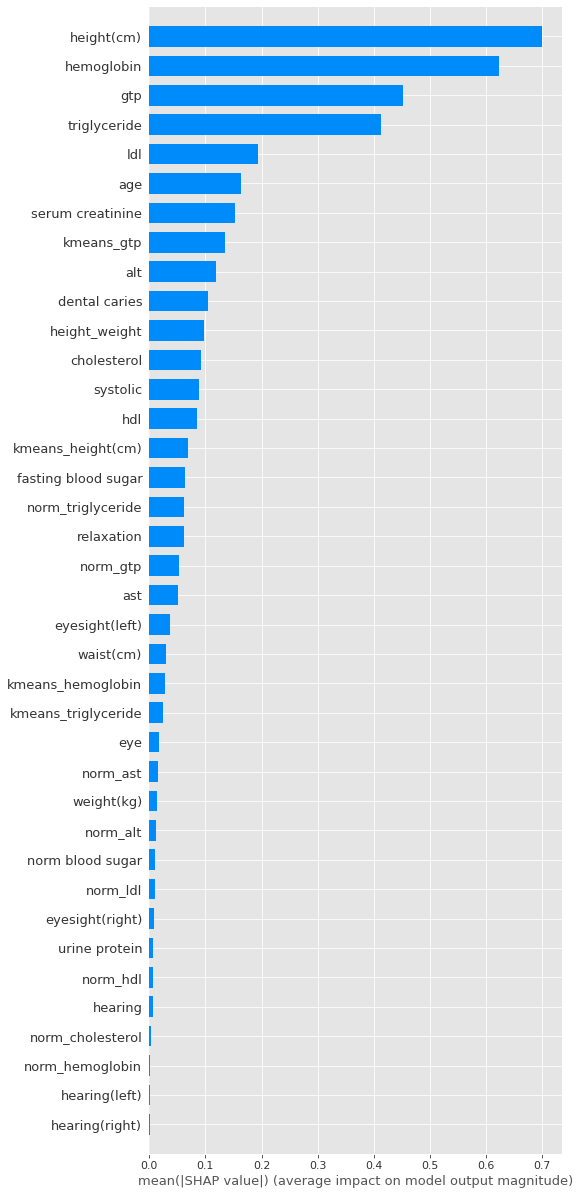

In [229]:
bad, best = shap_shap(X_train, model)

In [230]:
bad

[]

# group

In [39]:
def split_data_group(features: List, data):
    features_dict = dict()
    for i in tqdm(features):
        len_feature = data[i].nunique()
        list_feture = np.sort(data[i].unique())
        perc_02 = int(len_feature * 0.2)
        perc_04 = int(len_feature * 0.4)
        perc_06 = int(len_feature * 0.6)
        perc_08 = int(len_feature * 0.8)
        pp = -2
        for perc in [perc_02, perc_04, perc_06, perc_08, pp]:
            if perc == perc_02:
                list_f = list_feture[:perc]
            elif perc == perc_04:
                list_f = list_feture[perc_02:perc]
            elif perc == perc_06:
                list_f = list_feture[perc_04:perc]
            elif perc == perc_08:
                list_f = list_feture[perc_06:perc]
            elif perc == pp:
                list_f = list_feture[perc_08:]
            for p in list_f:
                features_dict[p] = np.sum(list_f)
        data[f'group_{i}'] = data[i].apply(lambda x: features_dict[x])
    return data

In [40]:
# best = best[:7]
best = ['height(cm)',
 'hemoglobin',
 'gtp',
 'triglyceride',
 'ldl',
 'age',
 'serum creatinine']

In [41]:
train = split_data_group(best, train)
test = split_data_group(best, test)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [173]:
model, X_train = fit_score(train)

x_train.shape: (101923, 41) x_valid.shape:  (31852, 41) y_train.shape:  (101923,) y_valid.shape:  (31852,) x_test.shape:  (25481, 41) y_test.shape:  (25481,)
0:	total: 15.9ms	remaining: 1m 19s
500:	total: 6.83s	remaining: 1m 1s
1000:	total: 13.7s	remaining: 54.6s
1500:	total: 20.8s	remaining: 48.5s
2000:	total: 27.9s	remaining: 41.9s
2500:	total: 35s	remaining: 35s
3000:	total: 42.5s	remaining: 28.3s
3500:	total: 50s	remaining: 21.4s
4000:	total: 57.4s	remaining: 14.3s
4500:	total: 1m 4s	remaining: 7.2s
4999:	total: 1m 12s	remaining: 0us
roc_auc_score:  0.7843771800092977
confusion_matrix:  [[13516  4322]
 [ 2648 11366]]
accuracy_score:  0.7811754363933191
test score:  0.77897


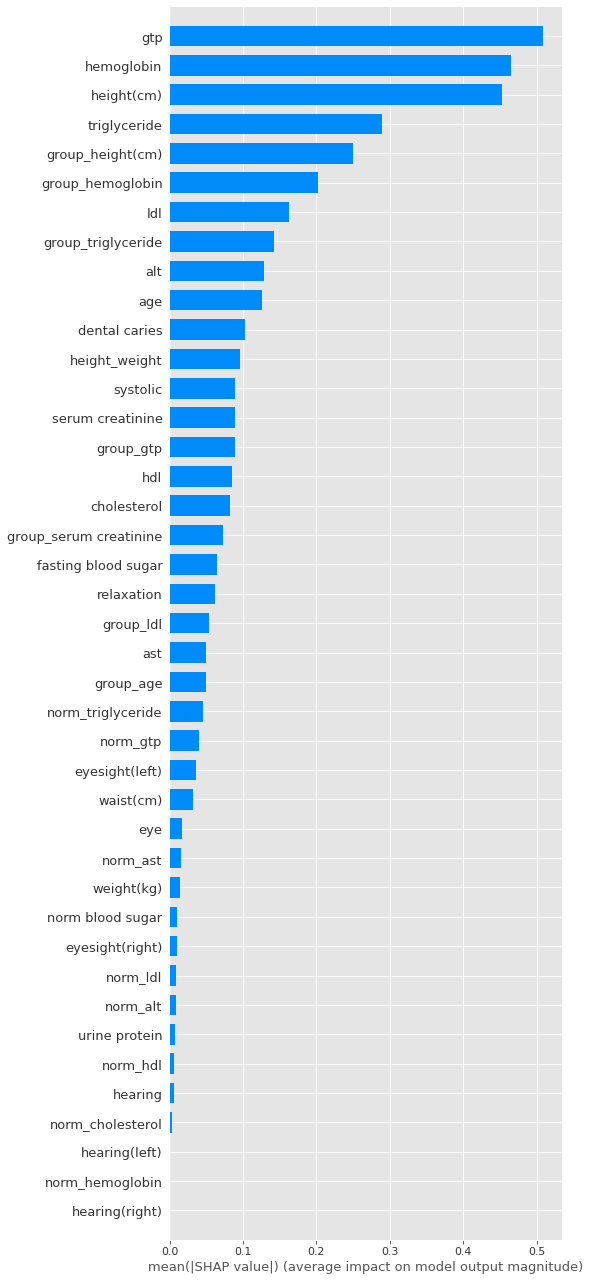

In [174]:
bad, best = shap_shap(X_train, model)

In [175]:
bad

[]

In [42]:
best = ['gtp',
 'hemoglobin',
 'height(cm)',
 'triglyceride',
 'group_height(cm)',
 'group_hemoglobin',
 'ldl',
 'group_triglyceride',
 'alt',
 'age',
 'dental caries',
 'height_weight',
 'systolic',
 'serum creatinine',
 'group_gtp',
 'hdl',
 'cholesterol',
 'group_serum creatinine',
 'fasting blood sugar',
 'relaxation',
 'group_ldl',
 'ast',
 'group_age',
 'norm_triglyceride',
 'norm_gtp',
 'eyesight(left)',
 'waist(cm)',
 'eye',
 'norm_ast',
 'weight(kg)',
 'norm blood sugar',
 'eyesight(right)',
 'norm_ldl',
 'norm_alt',
 'urine protein',
 'norm_hdl',
 'hearing',
 'norm_cholesterol',
 'hearing(left)',
 'norm_hemoglobin',
 'hearing(right)']

# kmeans

## cdist

In [43]:
X = train[best[:10]]

In [ ]:
# def dist(X, max_klaster=10):
#     distortions = []

#     K = range(1, max_klaster)

#     for k in K:
#         # Building and fitting the model
#         kmeanModel = KMeans(n_clusters=k).fit(X)
#         kmeanModel.fit(X)

#         distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
#                                             'euclidean'), axis=1)) / X.shape[0])
#     plt.plot(K, distortions, 'bx-')
#     plt.xlabel('Values of K')
#     plt.ylabel('Distortion')
#     plt.title('The Elbow Method using Distortion')
#     plt.show()

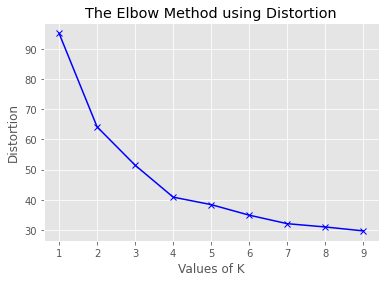

In [44]:
mc.dist_kmeans(X, 10)

In [45]:

for i in best[:10]:
    kmeans = KMeans(n_clusters=4, random_state=42).fit(train[[i]])
    train[f'kmeans_{i}'] = kmeans.labels_


In [46]:
for i in best[:10]:
    kmeans = KMeans(n_clusters=4, random_state=42).fit(test[[i]])
    test[f'kmeans_{i}'] = kmeans.labels_

In [50]:
train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine protein,serum creatinine,ast,alt,gtp,dental caries,smoking,norm_cholesterol,norm blood sugar,norm_triglyceride,norm_hdl,norm_ldl,norm_hemoglobin,norm_ast,norm_alt,norm_gtp,height_weight,eye,hearing,group_height(cm),group_hemoglobin,group_gtp,group_triglyceride,group_ldl,group_age,group_serum creatinine,kmeans_gtp,kmeans_hemoglobin,kmeans_height(cm),kmeans_triglyceride,kmeans_group_height(cm),kmeans_group_hemoglobin,kmeans_ldl,kmeans_group_triglyceride,kmeans_alt,kmeans_age
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,4.449,7.760,1.035,1.940,16.5,1,1.0,22,25,27,0,1,1,0,1,1,0,0,0,0,0,2.750000,1.1,2,335,237.3,630,464.820,42.240,154,2.1,0,2,1,3,2,3,3,2,0,3
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,5.018,1.423,1.474,3.259,16.2,1,1.1,27,23,37,1,0,1,1,0,0,0,0,0,0,0,2.538462,1.3,4,335,217.7,1479,96.146,69.607,279,2.1,2,2,1,1,2,0,2,1,0,1
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,4.604,5.096,1.164,2.406,17.4,1,0.8,27,31,53,0,1,1,0,1,0,0,0,0,0,0,2.266667,0.9,2,335,237.3,1479,276.230,55.924,75,1.7,2,2,3,0,2,3,1,0,0,2
3,35,180,95,104.0,1.5,1.2,1,1,131,88,91,4.656,5.251,0.983,2.638,15.9,1,1.0,20,27,30,1,0,1,0,1,1,0,0,0,0,0,1.894737,2.7,2,355,217.7,630,276.230,55.924,120,2.1,0,2,0,0,0,0,1,0,0,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,4.009,2.250,1.138,2.406,15.4,1,0.8,19,13,17,0,1,1,0,1,0,0,0,0,0,0,2.750000,2.5,2,335,217.7,630,96.146,55.924,75,1.7,0,0,1,1,2,0,1,1,1,2


In [47]:
model, X_train = fit_score(train)

x_train.shape: (101923, 51) x_valid.shape:  (31852, 51) y_train.shape:  (101923,) y_valid.shape:  (31852,) x_test.shape:  (25481, 51) y_test.shape:  (25481,)
0:	total: 202ms	remaining: 16m 48s
500:	total: 7.72s	remaining: 1m 9s
1000:	total: 15.1s	remaining: 1m
1500:	total: 22.5s	remaining: 52.5s
2000:	total: 29.9s	remaining: 44.9s
2500:	total: 37.4s	remaining: 37.4s
3000:	total: 45.1s	remaining: 30.1s
3500:	total: 52.9s	remaining: 22.6s
4000:	total: 1m	remaining: 15.1s
4500:	total: 1m 8s	remaining: 7.57s
4999:	total: 1m 16s	remaining: 0us
roc_auc_score:  0.7838674667635313
confusion_matrix:  [[13522  4316]
 [ 2667 11347]]
accuracy_score:  0.78076729875675
test score:  0.77762


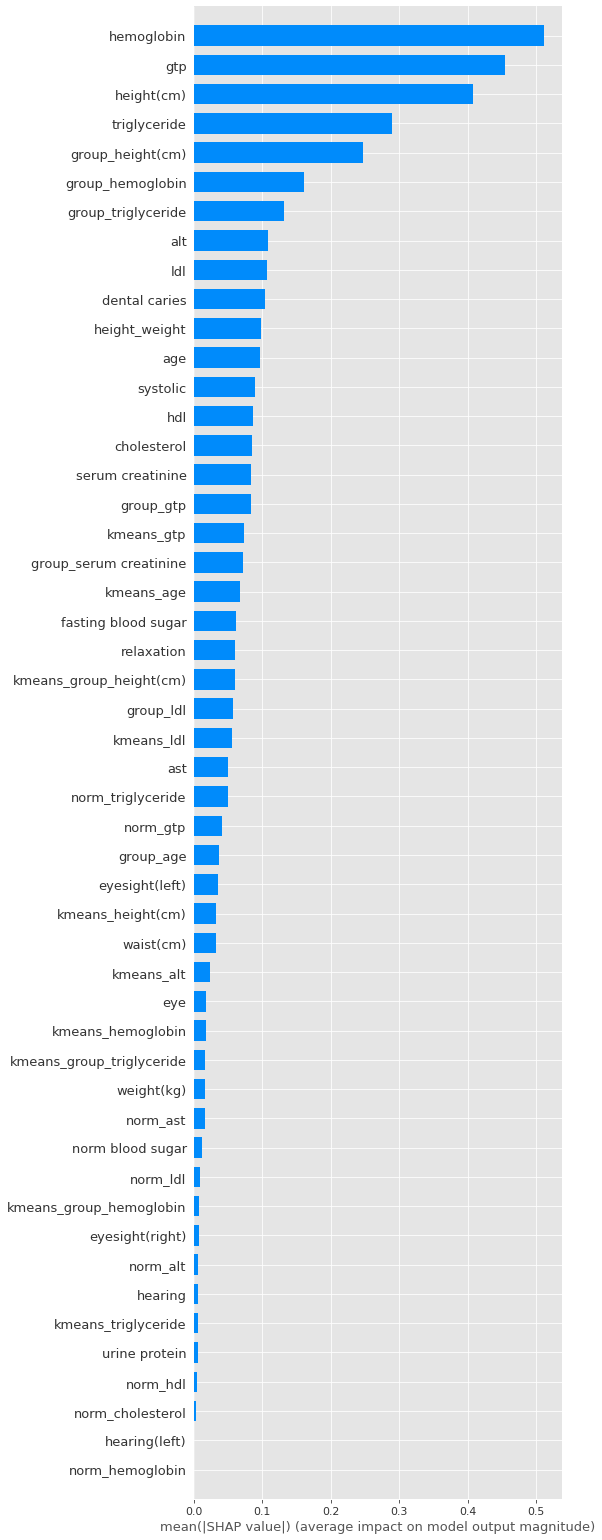

In [49]:
bad, best, bad_dict = shap_shap(X_train, model, 0.01)

In [50]:
bad_dict

{'hemoglobin': 0.511641173154035,
 'gtp': 0.454463097659453,
 'height(cm)': 0.40851460531001405,
 'triglyceride': 0.28965252264792896,
 'group_height(cm)': 0.24767974594645784,
 'group_hemoglobin': 0.16088763913183407,
 'group_triglyceride': 0.13200096874991638,
 'alt': 0.10883937243717311,
 'ldl': 0.10693234450202091,
 'dental caries': 0.10354078144536237,
 'height_weight': 0.09799031617333008,
 'age': 0.096629744577412,
 'systolic': 0.08960019215096898,
 'hdl': 0.08630325120476887,
 'cholesterol': 0.08521929173033832,
 'serum creatinine': 0.0841230827584232,
 'group_gtp': 0.08383351442161359,
 'kmeans_gtp': 0.07309856727379599,
 'group_serum creatinine': 0.07143476158960445,
 'kmeans_age': 0.06772403442189655,
 'fasting blood sugar': 0.062473475683533904,
 'relaxation': 0.060383022601495986,
 'kmeans_group_height(cm)': 0.060238553026745016,
 'group_ldl': 0.05783623153014554,
 'kmeans_ldl': 0.05659276265217924,
 'ast': 0.050472579187899005,
 'norm_triglyceride': 0.049563582780107224,


In [51]:
bad

['norm_ldl',
 'kmeans_group_hemoglobin',
 'eyesight(right)',
 'norm_alt',
 'hearing',
 'kmeans_triglyceride',
 'urine protein',
 'norm_hdl',
 'norm_cholesterol',
 'hearing(left)',
 'norm_hemoglobin',
 'hearing(right)']

In [52]:
t = train.copy()

In [53]:
t = t.drop(bad, axis=1)

In [54]:
model, X_train = fit_score(t)

x_train.shape: (101923, 39) x_valid.shape:  (31852, 39) y_train.shape:  (101923,) y_valid.shape:  (31852,) x_test.shape:  (25481, 39) y_test.shape:  (25481,)
0:	total: 30.9ms	remaining: 2m 34s
500:	total: 10.8s	remaining: 1m 37s
1000:	total: 18.3s	remaining: 1m 13s
1500:	total: 26s	remaining: 1m
2000:	total: 33.7s	remaining: 50.5s
2500:	total: 41.3s	remaining: 41.3s
3000:	total: 49.1s	remaining: 32.7s
3500:	total: 56.9s	remaining: 24.4s
4000:	total: 1m 5s	remaining: 16.2s
4500:	total: 1m 12s	remaining: 8.09s
4999:	total: 1m 20s	remaining: 0us
roc_auc_score:  0.7834597489707767
confusion_matrix:  [[13510  4328]
 [ 2669 11345]]
accuracy_score:  0.7803277659173679
test score:  0.77779


# categorical

In [55]:
base_columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'cholesterol', 'triglyceride',
       'hdl', 'ldl', 'hemoglobin', 'urine protein', 'serum creatinine', 'ast',
       'alt', 'gtp', 'dental caries'],
      dtype='object')

In [56]:
aggs = []
for i in train[base_columns].columns:
    if i == "smoking":
        continue
    if type(i) == int:
        continue
#     print(i)
    if i.split("_")[0] == "norm":
        continue
    if train[i].nunique() < 10:
        aggs.append(i)
aggs
print(len(aggs))
for i in aggs:
    
    print("*"*20)
    print(i)
    print("train : ", train[i].nunique())
    print(train[i].unique())
    
    print("test : ", test[i].nunique())
    print(test[i].unique())
    print(np.sort(train[i].unique()) == np.sort(test[i].unique()))

5
********************
hearing(left)
train :  2
[1 2]
test :  2
[1 2]
[ True  True]
********************
hearing(right)
train :  2
[1 2]
test :  2
[1 2]
[ True  True]
********************
urine protein
train :  3
[1 3 2]
test :  3
[1 2 3]
[ True  True  True]
********************
serum creatinine
train :  9
[1.  1.1 0.8 0.7 0.9 1.3 1.2 0.5 0.6]
test :  9
[0.9 1.1 1.3 0.6 1.  0.7 1.2 0.5 0.8]
[ True  True  True  True  True  True  True  True  True]
********************
dental caries
train :  2
[0 1]
test :  2
[0 1]
[ True  True]


In [57]:
train[aggs] = train[aggs].astype("str")
test[aggs] = test[aggs].astype("str")

In [58]:
# transformer = CategoricalFrequencyTransformer(use_cols=aggs)
train = mc.object_to_freq(train, aggs)
test = mc.object_to_freq(test, aggs)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.25it/s]


In [59]:
train.shape, test.shape

((159256, 57), (106171, 56))

In [60]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


In [61]:
onehotencoder = OneHotEncoder()

In [62]:
data_new = onehotencoder.fit_transform(train[aggs])
data_new = pd.DataFrame(data_new.toarray())
train[data_new.columns] = data_new

In [63]:
data_new_t = onehotencoder.fit_transform(test[aggs])
data_new_t = pd.DataFrame(data_new_t.toarray())
test[data_new_t.columns] = data_new_t

In [64]:
train.shape, test.shape

((159256, 75), (106171, 74))

In [65]:
le = dict()
labelencoder = LabelEncoder()
for col in train[aggs].columns:
    data_new = labelencoder.fit_transform(train[col].values)
    le = {k: v for k, v in zip(labelencoder.classes_, np.arange(len(labelencoder.classes_)))}
    train[f'le_{col}'] = train[col].apply(lambda x: le[x])

In [66]:
le = dict()
labelencoder = LabelEncoder()
for col in test[aggs].columns:
    data_new = labelencoder.fit_transform(test[col].values)
    le = {k: v for k, v in zip(labelencoder.classes_, np.arange(len(labelencoder.classes_)))}
    test[f'le_{col}'] = test[col].apply(lambda x: le[x])

In [67]:
train.shape, test.shape

((159256, 80), (106171, 79))

In [68]:
train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine protein,serum creatinine,ast,alt,gtp,dental caries,smoking,norm_cholesterol,norm blood sugar,norm_triglyceride,norm_hdl,norm_ldl,norm_hemoglobin,norm_ast,norm_alt,norm_gtp,height_weight,eye,hearing,group_height(cm),group_hemoglobin,group_gtp,group_triglyceride,group_ldl,group_age,group_serum creatinine,kmeans_gtp,kmeans_hemoglobin,kmeans_height(cm),kmeans_triglyceride,kmeans_group_height(cm),kmeans_group_hemoglobin,kmeans_ldl,kmeans_group_triglyceride,kmeans_alt,kmeans_age,hearing(left)_freq,hearing(right)_freq,urine protein_freq,serum creatinine_freq,dental caries_freq,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,le_hearing(left),le_hearing(right),le_urine protein,le_serum creatinine,le_dental caries
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,4.449,7.760,1.035,1.940,16.5,1,1.0,22,25,27,0,1,1,0,1,1,0,0,0,0,0,2.750000,1.1,2,335,237.3,630,464.820,42.240,154,2.1,0,2,1,3,2,3,3,2,0,3,0.976026,0.976579,0.947292,0.196621,0.802004,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,5,0
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,5.018,1.423,1.474,3.259,16.2,1,1.1,27,23,37,1,0,1,1,0,0,0,0,0,0,0,2.538462,1.3,4,335,217.7,1479,96.146,69.607,279,2.1,2,2,1,1,2,0,2,1,0,1,0.023974,0.023421,0.947292,0.111958,0.197996,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,0,6,1
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,4.604,5.096,1.164,2.406,17.4,1,0.8,27,31,53,0,1,1,0,1,0,0,0,0,0,0,2.266667,0.9,2,335,237.3,1479,276.230,55.924,75,1.7,2,2,3,0,2,3,1,0,0,2,0.976026,0.976579,0.947292,0.187133,0.802004,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,3,0
3,35,180,95,104.0,1.5,1.2,1,1,131,88,91,4.656,5.251,0.983,2.638,15.9,1,1.0,20,27,30,1,0,1,0,1,1,0,0,0,0,0,1.894737,2.7,2,355,217.7,630,276.230,55.924,120,2.1,0,2,0,0,0,0,1,0,0,0,0.976026,0.976579,0.947292,0.196621,0.197996,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,0,5,1
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,4.009,2.250,1.138,2.406,15.4,1,0.8,19,13,17,0,1,1,0,1,0,0,0,0,0,0,2.750000,2.5,2,335,217.7,630,96.146,55.924,75,1.7,0,0,1,1,2,0,1,1,1,2,0.976026,0.976579,0.947292,0.187133,0.802004,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,3,0


In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 80 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   age                        159256 non-null  int64  
 1   height(cm)                 159256 non-null  int64  
 2   weight(kg)                 159256 non-null  int64  
 3   waist(cm)                  159256 non-null  float64
 4   eyesight(left)             159256 non-null  float64
 5   eyesight(right)            159256 non-null  float64
 6   hearing(left)              159256 non-null  object 
 7   hearing(right)             159256 non-null  object 
 8   systolic                   159256 non-null  int64  
 9   relaxation                 159256 non-null  int64  
 10  fasting blood sugar        159256 non-null  int64  
 11  cholesterol                159256 non-null  float64
 12  triglyceride               159256 non-null  float64
 13  hdl                        15

In [70]:
train[aggs] = train[aggs].astype("float32")
test[aggs] = test[aggs].astype("float32")

In [71]:
model, X_train = fit_score(train)

x_train.shape: (101923, 79) x_valid.shape:  (31852, 79) y_train.shape:  (101923,) y_valid.shape:  (31852,) x_test.shape:  (25481, 79) y_test.shape:  (25481,)
0:	total: 32.2ms	remaining: 2m 40s
500:	total: 12.5s	remaining: 1m 52s
1000:	total: 21.6s	remaining: 1m 26s
1500:	total: 31.8s	remaining: 1m 14s
2000:	total: 44s	remaining: 1m 5s
2500:	total: 56.6s	remaining: 56.5s
3000:	total: 1m 8s	remaining: 45.8s
3500:	total: 1m 20s	remaining: 34.4s
4000:	total: 1m 31s	remaining: 22.8s
4500:	total: 1m 42s	remaining: 11.4s
4999:	total: 1m 53s	remaining: 0us
roc_auc_score:  0.7833654900830913
confusion_matrix:  [[13499  4339]
 [ 2663 11351]]
accuracy_score:  0.7801707899033028
test score:  0.77874


0.78007

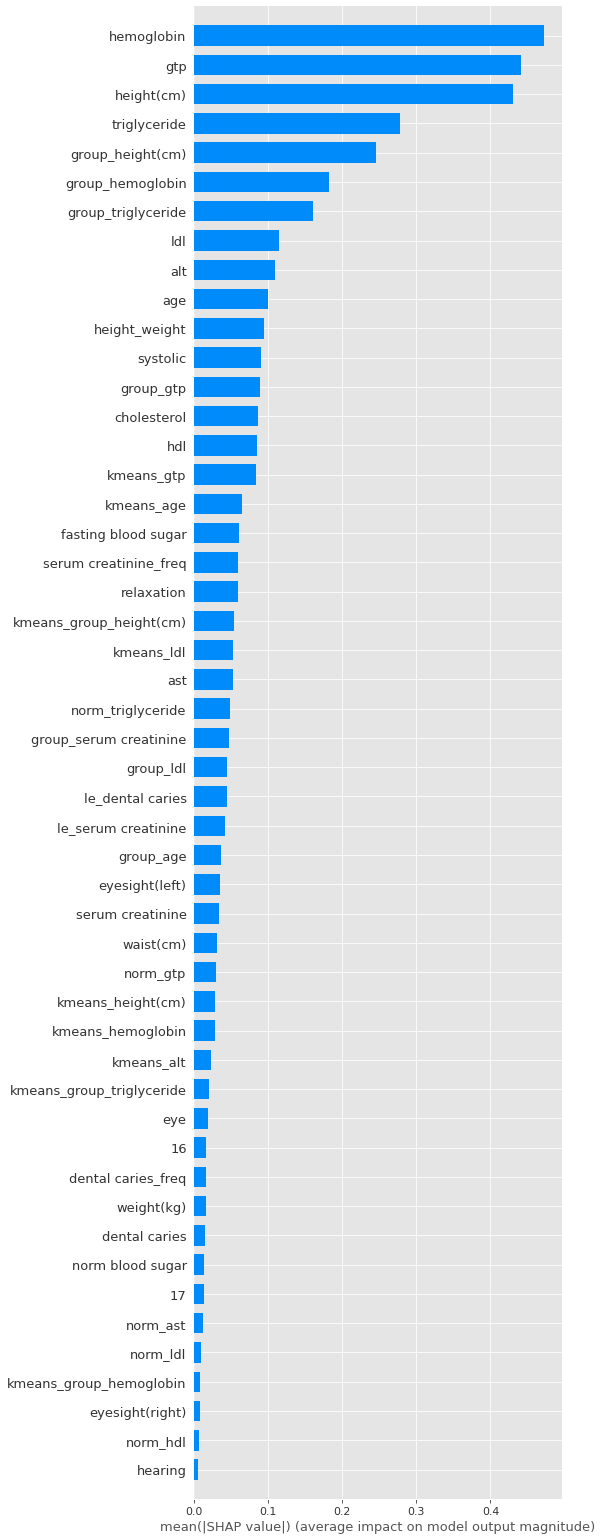

In [74]:
bad_sign, best_feature, dict_f = shap_shap(X_train, model)

In [76]:
bad_sign

['le_hearing(right)', 7]

In [79]:
dict_f

{'hemoglobin': 0.4722587118958772,
 'gtp': 0.4406836023956167,
 'height(cm)': 0.43077684819833534,
 'triglyceride': 0.2775408488106249,
 'group_height(cm)': 0.24617463095381878,
 'group_hemoglobin': 0.18203443058284705,
 'group_triglyceride': 0.16099881694744722,
 'ldl': 0.11513068339204538,
 'alt': 0.10959191311339977,
 'age': 0.10044301528820394,
 'height_weight': 0.09427009939479955,
 'systolic': 0.09132334122444097,
 'group_gtp': 0.08873966045328026,
 'cholesterol': 0.08619189917356689,
 'hdl': 0.08490889107333371,
 'kmeans_gtp': 0.08419822888432439,
 'kmeans_age': 0.06520307058877312,
 'fasting blood sugar': 0.06132918292228235,
 'serum creatinine_freq': 0.06006616305247999,
 'relaxation': 0.059544848712040924,
 'kmeans_group_height(cm)': 0.05487060746415991,
 'kmeans_ldl': 0.05338903950593984,
 'ast': 0.05286639657351856,
 'norm_triglyceride': 0.04843088598908097,
 'group_serum creatinine': 0.04696051794334342,
 'group_ldl': 0.04550446089447367,
 'le_dental caries': 0.04539323470

In [80]:
# t = train.copy()
train = train.drop(bad_sign, axis=1)
test = test.drop(bad_sign, axis=1)

In [78]:
model, X_train = fit_score(train)

x_train.shape: (101923, 77) x_valid.shape:  (31852, 77) y_train.shape:  (101923,) y_valid.shape:  (31852,) x_test.shape:  (25481, 77) y_test.shape:  (25481,)
0:	total: 48.5ms	remaining: 4m 2s
500:	total: 12.7s	remaining: 1m 54s
1000:	total: 21.7s	remaining: 1m 26s
1500:	total: 30.8s	remaining: 1m 11s
2000:	total: 40.1s	remaining: 1m
2500:	total: 49.6s	remaining: 49.5s
3000:	total: 59.2s	remaining: 39.4s
3500:	total: 1m 8s	remaining: 29.5s
4000:	total: 1m 18s	remaining: 19.6s
4500:	total: 1m 28s	remaining: 9.81s
4999:	total: 1m 38s	remaining: 0us
roc_auc_score:  0.7835387547438866
confusion_matrix:  [[13509  4329]
 [ 2666 11348]]
accuracy_score:  0.7803905563229938
test score:  0.77874


0.77854

In [144]:
# bad_sign, best_feature = shap_shap(X_train, model)

In [145]:
# bad_sign, len(best_feature)

In [81]:
train.shape, test.shape

((159256, 78), (106171, 77))

In [148]:
train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine protein,serum creatinine,ast,alt,gtp,dental caries,smoking,norm_cholesterol,norm blood sugar,norm_triglyceride,norm_hdl,norm_ldl,norm_hemoglobin,norm_ast,norm_alt,norm_gtp,height_weight,eye,hearing,hearing(left)_freq,hearing(right)_freq,urine protein_freq,serum creatinine_freq,dental caries_freq,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,le_hearing(left),le_hearing(right),le_urine protein,le_serum creatinine,le_dental caries
0,55,165,60,81.0,0.5,0.6,1.0,1.0,135,87,94,4.449,7.760,1.035,1.940,16.5,1.0,1.0,22,25,27,0.0,1,1,0,1,1,0,0,0,0,0,2.750000,1.1,2,0.976026,0.976579,0.947292,0.196621,0.802004,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,5,0
1,70,165,65,89.0,0.6,0.7,2.0,2.0,146,83,147,5.018,1.423,1.474,3.259,16.2,1.0,1.1,27,23,37,1.0,0,1,1,0,0,0,0,0,0,0,2.538462,1.3,4,0.023974,0.023421,0.947292,0.111958,0.197996,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,0,6,1
2,20,170,75,81.0,0.4,0.5,1.0,1.0,118,75,79,4.604,5.096,1.164,2.406,17.4,1.0,0.8,27,31,53,0.0,1,1,0,1,0,0,0,0,0,0,2.266667,0.9,2,0.976026,0.976579,0.947292,0.187133,0.802004,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,3,0
3,35,180,95,104.0,1.5,1.2,1.0,1.0,131,88,91,4.656,5.251,0.983,2.638,15.9,1.0,1.0,20,27,30,1.0,0,1,0,1,1,0,0,0,0,0,1.894737,2.7,2,0.976026,0.976579,0.947292,0.196621,0.197996,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,0,5,1
4,30,165,60,80.5,1.5,1.0,1.0,1.0,121,76,91,4.009,2.250,1.138,2.406,15.4,1.0,0.8,19,13,17,0.0,1,1,0,1,0,0,0,0,0,0,2.750000,2.5,2,0.976026,0.976579,0.947292,0.187133,0.802004,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,3,0


In [82]:
train.to_csv("data/train_new.csv", index=False)
test.to_csv("data/test_new.csv", index=False)

## stat features

In [4]:
train = pd.read_csv("data/train_new.csv")
test = pd.read_csv("data/test_new.csv")

In [5]:
train.shape, test.shape

((159256, 78), (106171, 77))

In [7]:
best = ['hemoglobin', 'gtp', 'height(cm)', 'triglyceride', 'group_height(cm)']
# best = list(dict_f.keys())[:5]
best

['hemoglobin', 'gtp', 'height(cm)', 'triglyceride', 'group_height(cm)']

In [8]:
%%time
funk = 'mean'
j = 0
for feature in tqdm(best):

    data_grouped = train.groupby(train[feature])
    stats = data_grouped.agg(funk)

    stats.columns = [f"{j}_{i}_{funk}".upper() for i in stats]
    stats = stats.reset_index()
    
    train = train.merge(stats, how="left", on=feature)
    j += 1
print(train.shape)
print("test...")
j = 0
for feature in tqdm(best):

    data_grouped = test.groupby(test[feature])
    stats = data_grouped.agg(funk)

    stats.columns = [f"{j}_{i}_{funk}".upper() for i in stats]
    stats = stats.reset_index()
    
    test = test.merge(stats, how="left", on=feature)
    j += 1
print(test.shape)


  0%|          | 0/5 [00:00<?, ?it/s]

(159256, 2465)
test...


  0%|          | 0/5 [00:00<?, ?it/s]

(106171, 2433)
Wall time: 29.9 s


In [9]:
cols1, cols2 = train.columns, test.columns

In [10]:
cols3 = [i for i in cols1 if i in cols2]
target = train['smoking']
print(len(cols3))

2433


In [11]:
train = train[cols3]
test = test[cols3]
train['smoking'] = target

In [12]:
train.shape, test.shape

((159256, 2434), (106171, 2433))

In [13]:
%%time
model, X_train = fit_score(train)

x_train.shape: (101923, 2433) x_valid.shape:  (31852, 2433) y_train.shape:  (101923,) y_valid.shape:  (31852,) x_test.shape:  (25481, 2433) y_test.shape:  (25481,)
0:	total: 521ms	remaining: 43m 24s
500:	total: 2m 44s	remaining: 24m 38s
1000:	total: 5m 26s	remaining: 21m 44s
1500:	total: 8m 11s	remaining: 19m 6s
2000:	total: 10m 49s	remaining: 16m 12s
2500:	total: 13m 23s	remaining: 13m 22s
3000:	total: 16m	remaining: 10m 39s
3500:	total: 18m 38s	remaining: 7m 58s
4000:	total: 21m 14s	remaining: 5m 18s
4500:	total: 23m 53s	remaining: 2m 38s
4999:	total: 26m 30s	remaining: 0us
roc_auc_score:  0.784329368290001
confusion_matrix:  [[13596  4187]
 [ 2756 11313]]
accuracy_score:  0.7820231068692703
test score:  0.78076
Wall time: 27min 32s


In [ ]:
def shap_shap(X_train, model, shap_limit=0):
    np.random.seed(10)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    # Суммированная важность признаков
    shap.summary_plot(
        shap_values, X_train, plot_type="bar", max_display=50)
    
    shap_values_importance = pd.DataFrame({
    "importance": np.abs(shap_values).mean(axis=0),
    "feature": X_train.columns
        })
    shap_values_importance = shap_values_importance.sort_values(
        by="importance", ascending=False
        )
    shap_values_importance = shap_values_importance.reset_index(drop=True) 
    
    
#     print(shap_values_importance)
    # Набор топ признаков
    best_feature = shap_values_importance.feature.to_list()
    dict_features = dict(zip(best_feature, shap_values_importance["importance"]))
    # Набор признаков для удаления
    features_to_drop = shap_values_importance[shap_values_importance["importance"] <= shap_limit]
    features_to_drop = features_to_drop.feature.to_list()
    
    return features_to_drop, dict_features

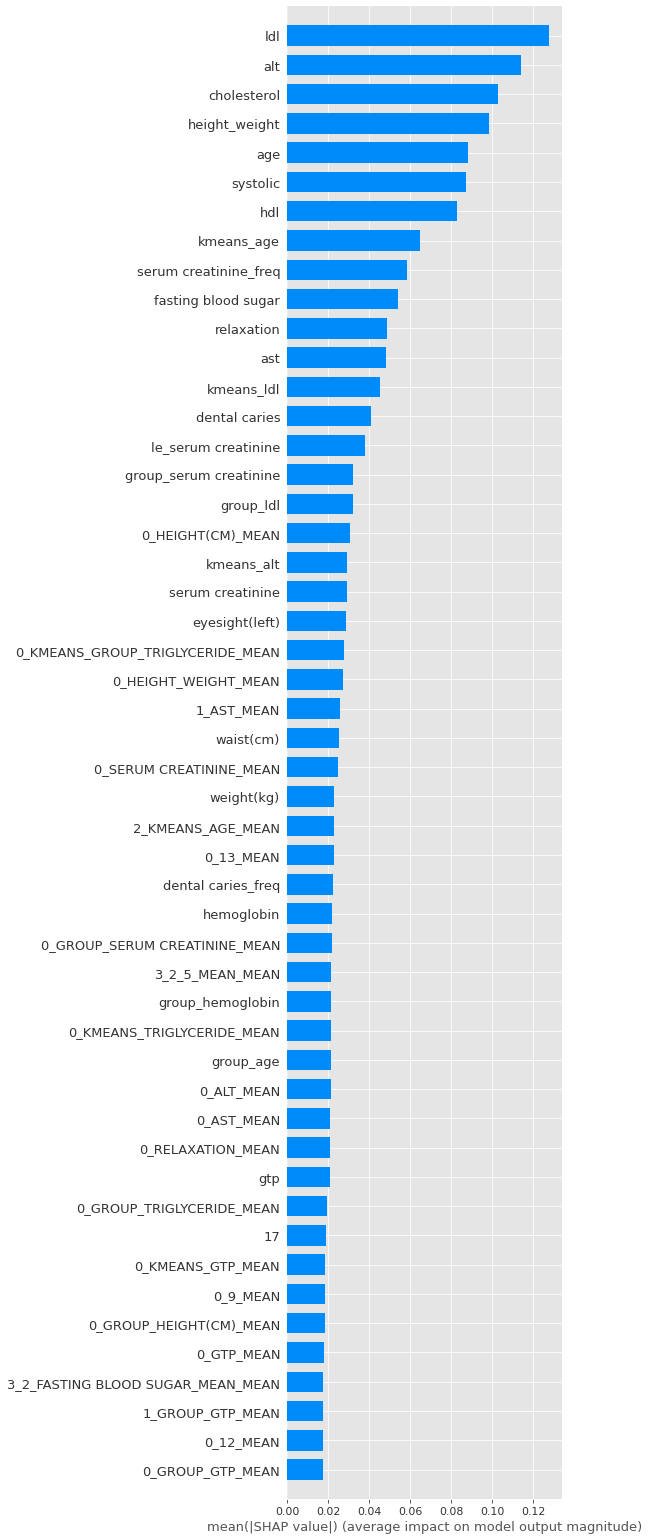

In [15]:
bad_sign, dict_f = shap_shap(X_train, model)

In [18]:
train.to_csv("data/train_new_all.csv", index=False)
test.to_csv("data/test_new_all.csv", index=False)

In [19]:
import json
with open('dict_features.json', 'w') as fp:
    json.dump(dict_f, fp)

In [6]:
os.listdir("data")

['sample_submission.csv',
 'test.csv',
 'test_new.csv',
 'test_new.zip',
 'test_new_1.csv',
 'test_new_all.csv',
 'train.csv',
 'train_new.csv',
 'train_new_1.csv',
 'train_new_all.csv']

In [8]:
train = pd.read_csv("data/train_new_all.csv")
test = pd.read_csv("data/test_new_all.csv")

In [9]:
train.shape, test.shape

((159256, 2434), (106171, 2433))

In [11]:
dict_features = pd.read_json("dict_features.json", orient='index')
dict_features = dict_features.reset_index()
dict_f = dict(zip(dict_features['index'], dict_features[0]))
# dict_f

In [17]:
dict_f.values() 

False

In [22]:
features = [k for k, v in dict_f.items() if v != 0]

In [25]:
t = train[features].copy()
t['smoking'] = train['smoking']

In [26]:
t.shape

(159256, 1667)

In [28]:
%%time
model, X_train = fit_score(t)

x_train.shape: (101923, 1666) x_valid.shape:  (31852, 1666) y_train.shape:  (101923,) y_valid.shape:  (31852,) x_test.shape:  (25481, 1666) y_test.shape:  (25481,)
0:	total: 326ms	remaining: 27m 10s
500:	total: 2m 15s	remaining: 20m 15s
1000:	total: 4m 22s	remaining: 17m 29s
1500:	total: 6m 28s	remaining: 15m 5s
2000:	total: 8m 30s	remaining: 12m 45s
2500:	total: 10m 32s	remaining: 10m 32s
3000:	total: 12m 33s	remaining: 8m 22s
3500:	total: 14m 36s	remaining: 6m 15s
4000:	total: 16m 38s	remaining: 4m 9s
4500:	total: 18m 40s	remaining: 2m 4s
4999:	total: 20m 43s	remaining: 0us
roc_auc_score:  0.7833167239584812
confusion_matrix:  [[13584  4199]
 [ 2775 11294]]
accuracy_score:  0.7810498555820671
test score:  0.78264
Wall time: 21min 7s


0.78076

In [29]:
target = train['smoking']
train = train[features]
train['smoking'] = target
test = test[features]

In [30]:
train.shape, test.shape

((159256, 1667), (106171, 1666))

In [31]:
train.to_csv("data/train_new_all.csv", index=False)
test.to_csv("data/test_new_all.csv", index=False)

In [ ]:
bad, dict_features = shapr_shap(model, X_train)

### test

In [16]:
def fit_score(X):
    x_train, x_valid, y_train, y_valid, x_test, y_test = mc.train_split(X, "smoking")

    params = {
        "n_estimators": 5000,
        "learning_rate": 0.01,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",
        #"max_bin": 20,
        "verbose": 500,
        "max_depth": 6,
        "l2_leaf_reg": 10,
        "early_stopping_rounds": 50,
        "thread_count": 6,
        "random_seed": 42
        }
    model, rocauc_score = mc.catboost_base(x_train, x_valid, y_train, y_valid, params=params)
    pred = model.predict_proba(x_test)[:,1]
    pred = np.where(pred > 0.5, 1, 0)
    print("test score: ", round(roc_auc_score(pred, y_test), 5))
    return model, x_train, rocauc_score

In [17]:
data_scoring = pd.DataFrame(columns=["del_sign", "scoreAUC", "check_best"])
check_cols = list(dict_f.keys())
check_cols.reverse()
all_sign_roc = 0.77874
for col in tqdm(range(check_cols)):
    t = train.copy()
    t = t.drop(col, axis=1)
    model, x_train, rocauc_score = fit_score(t)
    d = dict()
    d["del_sign"] = col
    d["scoreAUC"] = rocauc_score
    d["check_best"] = 1 if rocauc_score > all_sign_roc else 0
    if rocauc_score > all_sign_roc:
        print("на признаке {}, auc: {}, он больше на {}".format(col, rocauc_score, rocauc_score-all_sign_roc))
    data_scoring  = data_scoring.append(d)
        

AttributeError: 'list' object has no attribute 'reverce'

In [ ]:
data_scoring.to_csv("data/data_scoring.csv")

## transformer

In [56]:
def transformer(train, test, cont_cols, target):
    '''
    Алгоритм применяет множественные преобразования к выбранным столбцам и 
    находит наилучшее преобразование, используя одну переменную производительности модели  
    '''
    train_copy = train.copy()
    test_copy = test.copy()
    for col in cont_cols:
                
        # Log Transformation after MinMax Scaling (keeps data between 0 and 1)
        train_copy["log_"+col] = np.log1p(train_copy[col])
        test_copy["log_"+col] = np.log1p(test_copy[col])
        
        # Square Root Transformation
        train_copy["sqrt_"+col] = np.sqrt(train_copy[col])
        test_copy["sqrt_"+col] = np.sqrt(test_copy[col])
        
        # Box-Cox transformation
        epsilon = 1e-5
        transformer = PowerTransformer(method='box-cox')

        train_copy["bx_cx_" + col] = transformer.fit_transform(train_copy[[col]] + epsilon)
        test_copy["bx_cx_" + col] = transformer.fit_transform(test_copy[[col]] + epsilon)
        
        # Yeo-Johnson transformation
        transformer = PowerTransformer(method='yeo-johnson')
        train_copy["y_J_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["y_J_"+col] = transformer.transform(test_copy[[col]])
        
        # Power transformation, 0.25
        power_transform = lambda x: np.power(x + 1 - np.min(x), 0.25)
        transformer = FunctionTransformer(power_transform)
        train_copy["pow_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["pow_"+col] = transformer.transform(test_copy[[col]])
        
        # Power transformation, 2
        power_transform = lambda x: np.power(x + 1 - np.min(x), 2)
        transformer = FunctionTransformer(power_transform)
        train_copy["pow2_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["pow2_"+col] = transformer.transform(test_copy[[col]])
        
        # Log to power transformation
        train_copy["log_sqrt"+col] = np.log1p(train_copy["sqrt_"+col])
        test_copy["log_sqrt"+col] = np.log1p(test_copy["sqrt_"+col])
        
        temp_cols = [col, "log_"+col, "sqrt_"+col, "bx_cx_"+col, "y_J_"+col,  "pow_"+col , "pow2_"+col,"log_sqrt"+col]
        
        pca = TruncatedSVD(n_components=1)
        x_pca_train = pca.fit_transform(train_copy[temp_cols])
        x_pca_test = pca.transform(test_copy[temp_cols])
        x_pca_train = pd.DataFrame(x_pca_train, columns=[col+"_pca_comb"])
        x_pca_test = pd.DataFrame(x_pca_test, columns=[col+"_pca_comb"])
        temp_cols.append(col+"_pca_comb")
        
        test_copy = test_copy.reset_index(drop=True)
        
        train_copy = pd.concat([train_copy, x_pca_train], axis='columns')
        test_copy = pd.concat([test_copy, x_pca_test], axis='columns')
        
    return train_copy, test_copy

In [57]:
train.shape, test.shape

((159256, 63), (106171, 62))

In [59]:
train = mc.transformer(train, aggs, "smoking")
test = mc.transformer(test, aggs, "smoking")

divide by zero encountered in log
divide by zero encountered in log
overflow encountered in power
overflow encountered in multiply
divide by zero encountered in log
overflow encountered in power
overflow encountered in multiply


In [60]:
train.shape, test.shape

((159256, 103), (106171, 102))

In [61]:
model, X_train = fit_score(train)

x_train.shape: (101923, 102) x_valid.shape:  (31852, 102) y_train.shape:  (101923,) y_valid.shape:  (31852,) x_test.shape:  (25481, 102) y_test.shape:  (25481,)
0:	total: 16.5ms	remaining: 1m 22s
500:	total: 7.99s	remaining: 1m 11s
1000:	total: 15.9s	remaining: 1m 3s
1500:	total: 24.1s	remaining: 56.2s
2000:	total: 32.4s	remaining: 48.5s
2500:	total: 40.5s	remaining: 40.5s
3000:	total: 48.8s	remaining: 32.5s
3500:	total: 57.2s	remaining: 24.5s
4000:	total: 1m 5s	remaining: 16.4s
4500:	total: 1m 13s	remaining: 8.2s
4999:	total: 1m 22s	remaining: 0us
roc_auc_score:  0.7842802689278111
confusion_matrix:  [[13538  4300]
 [ 2668 11346]]
accuracy_score:  0.7812382267989452
test score:  0.77978


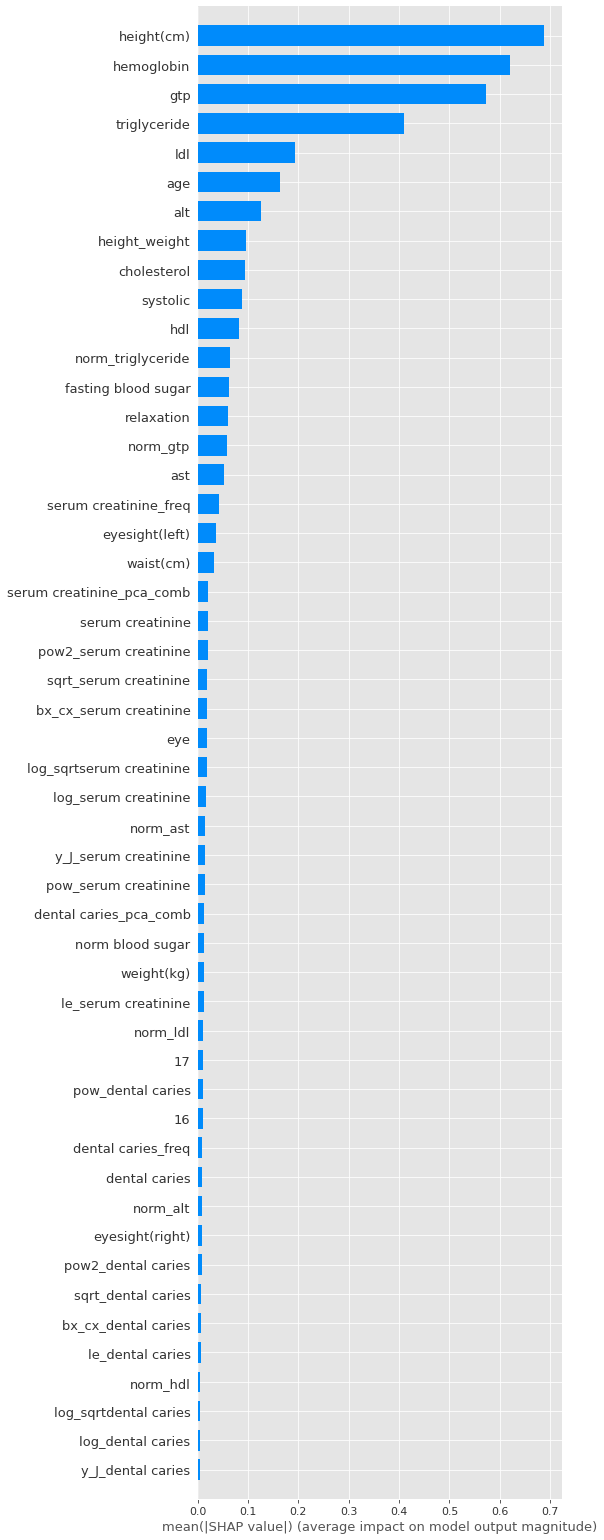

In [62]:
bad_features, best_features = mc.shap(model, X_train)

In [63]:
bad_features

['y_J_hearing(right)', 'bx_cx_hearing(left)', 'y_J_hearing(left)', 7]

In [ ]:
# train_t = train.copy()
# test_t = test.copy()

In [64]:
train = train.drop(bad_features, axis=1)
test = test.drop(bad_features, axis=1)

In [65]:
model, X_train = fit_score(train)

x_train.shape: (101923, 98) x_valid.shape:  (31852, 98) y_train.shape:  (101923,) y_valid.shape:  (31852,) x_test.shape:  (25481, 98) y_test.shape:  (25481,)
0:	total: 19ms	remaining: 1m 35s
500:	total: 8.44s	remaining: 1m 15s
1000:	total: 16.9s	remaining: 1m 7s
1500:	total: 25.7s	remaining: 59.8s
2000:	total: 34.3s	remaining: 51.5s
2500:	total: 42.9s	remaining: 42.8s
3000:	total: 51.5s	remaining: 34.3s
3500:	total: 1m	remaining: 25.8s
4000:	total: 1m 9s	remaining: 17.2s
4500:	total: 1m 17s	remaining: 8.63s
4999:	total: 1m 26s	remaining: 0us
roc_auc_score:  0.7848842410612629
confusion_matrix:  [[13543  4295]
 [ 2655 11359]]
accuracy_score:  0.7818033404495793
test score:  0.77963


In [66]:
train.to_csv("data/train_new_1.csv", index=False)
test.to_csv("data/test_new_1.csv", index=False)